# Data Cleaning and EDA

In [1]:
## Import libraries
import pandas as pd
import numpy as np

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import re

import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB, BernoulliNB ,GaussianNB

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import warnings

from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
# Set to ignore any warnings
warnings.filterwarnings('ignore')

In [2]:
## load training data
df= pd.read_csv("train.csv")

In [3]:
df.index = df['id']

In [4]:
# Drop column 'id'
data = df.drop(columns = ['id'])

In [5]:
data.reset_index(inplace= True)

In [6]:
# Drop column 'id'
data = data.drop(columns = ['id'])

In [7]:
data.head()

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
keywords = []
for i in data['keyword'].values:
    keywords.append(re.sub(r'%20', ' ', str(i)))

In [9]:
data['keyword'] = keywords

In [10]:
data.head()  ## display the 1st 10 rows of the dataframe

,keyword,location,text,target
0,nan,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,nan,NaN,Forest fire near La Ronge Sask. Canada,1
2,nan,NaN,All residents asked to 'shelter in place' are ...,1
3,nan,NaN,"13,000 people receive #wildfires evacuation or...",1
4,nan,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Removing unncesaray words from text

In [11]:
text = pd.Series(data['text'])

In [12]:
## Cleaning function Kalpa:
def clean_the_text(text_1):  #input should be a series
    # Remove the unnecessary pattern starting from Û
    import re
    import pandas as pd
    import numpy as np
    new_text = []
    for j in range(len(text_1)):
        result = re.sub(r'\b[Û\\n]\w*\b', '', text_1[j].lower())
        new_text.append(result)
    
    ## Remove urls
    new_text_1 = []
    for j in range(len(new_text)):
        result = re.sub(r'http[s]?://\S+', '', new_text[j])
        new_text_1.append(result)
    
    
    ## Remove non-english 
    new_text_2 = []
    for j in range(len(new_text_1)):
        result = re.sub(r'[^\x00-\x7F]+', '', new_text_1[j])
        new_text_2.append(result)
    
    ## Remove => in text
    new_text_3 = []
    for j in range(len(new_text_2)):
        result = re.sub(r'[=>.]', '', new_text_2[j])
        new_text_3.append(result)
    
    
    ## Remove the word 'amp' which is a high frequency word in text
    new_text_4 = []
    for j in range(len(new_text_3)):
        result = re.sub(r'amp', '', new_text_3[j])
        new_text_4.append(result)

    return pd.Series(new_text_4)  ## return a series

#cite : https://stackoverflow.com/questions/20078816/replace-non-ascii-characters-with-a-single-space

In [13]:
## Add the cleaned text into the data DataFrame
data['text']=clean_the_text(text)

In [14]:
data = data.loc[:,['text','target']]

In [15]:
data.head(8)

,text,target
0,our deeds are the reason of this #earthquake m...,1
1,forest fire la ronge sask canada,1
2,all residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,just got sent this photo from ruby #alaska as ...,1
5,#rockyfire update california hwy 20 closed in...,1
6,#flood #disaster heavy rain causes flash flood...,1
7,i'm on top of the hill and i can see a fire in...,1


In [16]:
## List of text/tweets indicating a disaster
disaster = [text for i, text in enumerate(data['text']) if data['target'][i] == 1]

In [17]:
## List of text/tweets not indicating a disaster
not_disaster = [text for i, text in enumerate(data['text']) if data['target'][i] == 0]

In [18]:
# Instantiate a CountVectorizer.
cvec_1 = CountVectorizer()
cvec_2 = CountVectorizer()

# list of english stopwords
stop_words = set(stopwords.words('english'))

#Removing stopwords
cvec_1.set_params(stop_words=list(stop_words))
cvec_2.set_params(stop_words=list(stop_words))

# Transform the corpus.
disaster_cv = cvec_1.fit_transform(disaster)
not_disaster_cv = cvec_2.fit_transform(not_disaster)

# Plot the word cloud

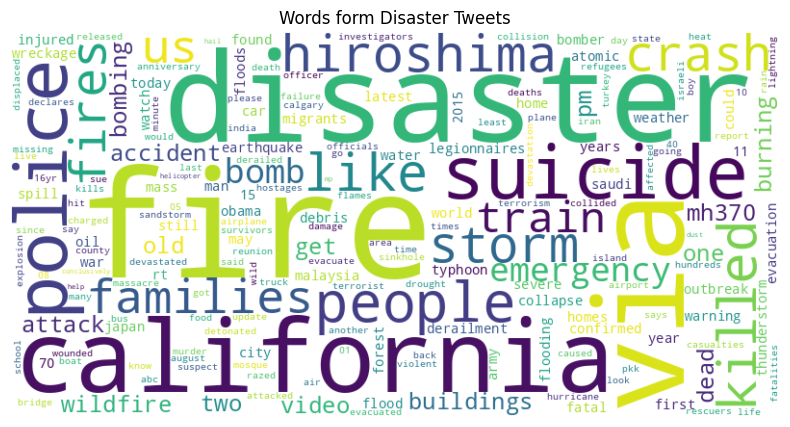

In [19]:
# Convert the list into a DataFrame.
X_df = pd.DataFrame(disaster_cv.todense(), columns=cvec_1.get_feature_names_out())

# Convert the feature names and their counts into a dictionary
word_frequency = dict(zip(cvec_1.get_feature_names_out(), X_df.sum(axis=0)))

# Create a WordCloud object
wc = WordCloud(width=800, height=400, background_color='white')

# Generate the word cloud 
wc.generate_from_frequencies(word_frequency)

# plot
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.title('Words form Disaster Tweets')
plt.axis('off')
plt.show()

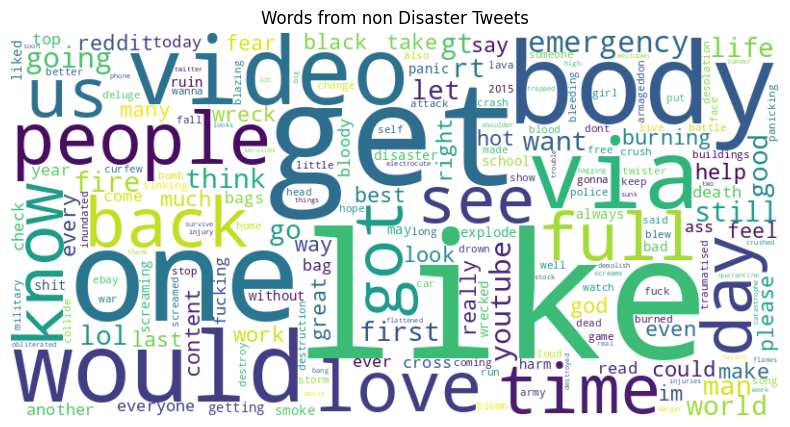

In [20]:
# Convert the list into a DataFrame.
X_df = pd.DataFrame(not_disaster_cv.todense(), columns=cvec_2.get_feature_names_out())

# Convert the feature names and their counts into a dictionary
word_frequency = dict(zip(cvec_2.get_feature_names_out(), X_df.sum(axis=0)))

# Create a WordCloud object
wc = WordCloud(width=800, height=400, background_color='white')

# Generate the word cloud 
wc.generate_from_frequencies(word_frequency)

# plot
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.title('Words from non Disaster Tweets')
plt.axis('off')
plt.show()

# Modeling Section

In [21]:
#define X,y 
X= pd.Series(data['text'])
y = data['target']

In [22]:
#Data size
X.shape, y.shape

((7613,), (7613,))

In [23]:
#check the baseline score
y.value_counts(normalize=True)

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

In [24]:
#Train test split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

# The Models used here for testing:

---

- LogisticRegressionCV
- RandomForestClassifier
- KNN Classifier
- BernoulliNB
- Support Vector Machine Classifier
- AdaBoostClassifier(with RandomForestClassifier estimator)

# LogisticRegressionCV

In [25]:
# Let's set a pipeline up with two stages:
pipe_logr = Pipeline([
    ('vec', CountVectorizer()),
    ('logr', LogisticRegressionCV(max_iter=5000,solver = 'lbfgs'))
])

In [26]:
pipe_params_logr = {
    'vec': [CountVectorizer(), TfidfVectorizer()],
    'vec__max_features' : [5000],
    'vec__min_df' : [5],#[3,5]
    'vec__max_df' : [0.9],#0.95],
    'vec__ngram_range' : [(1,2)],#(1,1)],
    'vec__stop_words' : [ None, 'english']
}

In [27]:
# Instantiate GridSearchCV for LogisticRegressionCV
gs_logr = GridSearchCV(pipe_logr,     # what object are we optimizing?
                  pipe_params_logr,   # what parameters values are we searching?
                  cv=5)               # 5-fold cross-validation.

In [28]:
# Fit GridSearch to training data.
gs_logr.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(max_iter=5000))]),
             param_grid={'vec': [CountVectorizer(max_df=0.9, max_features=5000,
                                                 min_df=5, ngram_range=(1, 2)),
                                 TfidfVectorizer()],
                         'vec__max_df': [0.9], 'vec__max_features': [5000],
                         'vec__min_df': [5], 'vec__ngram_range': [(1, 2)],
                         'vec__stop_words': [None, 'english']})

In [29]:
gs_logr.best_params_

{'vec': CountVectorizer(max_df=0.9, max_features=5000, min_df=5, ngram_range=(1, 2)),
 'vec__max_df': 0.9,
 'vec__max_features': 5000,
 'vec__min_df': 5,
 'vec__ngram_range': (1, 2),
 'vec__stop_words': None}

In [30]:
# Get predictions
preds_logr = gs_logr.predict(X_test)

In [31]:
def evaluation(name_of_the_model ,y_test,preds,gs_model):
    ## find the confusion matrix
    cm = confusion_matrix(y_test,preds)
    tp = cm[1][1]; #True positives
    tn = cm[0][0]; #True negatives
    fp = cm[0][1]; #False positives
    fn = cm[1][0]; #False negatives

    #Calculate Sensitivity, Specificity, Precision, and F1_Score

    Sensitivity = round(tp/(tp+fn),3)
    Specificity = round(tn/(tn+fp),3)
    Precision = round(tp / (tp + fp),3)
    F1_Score = round(2 * (Precision * Sensitivity) / (Precision + Sensitivity),3)

    #Model scores for train and test

    train_score = round(gs_model.score(X_train, y_train),3)
    test_score = round(gs_model.score(X_test,y_test),3)

    #Create a dataframe to compare the results
    df = pd.DataFrame(
        {'Model' :name_of_the_model,
        'Score on train':train_score ,
        'Score on test': test_score,
         'Sensitivity':Sensitivity,
         'Specificity':Specificity,
         'Precision' : Precision,
         'F1 Score' : F1_Score
        },index=[0]
    )

    return df #Display the dataframe

In [32]:
logr = evaluation('logr',y_test,preds_logr,gs_logr)
logr

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,logr,0.885,0.808,0.706,0.889,0.835,0.765


# RandomForestClassifier

In [33]:
# Define the pipeline with FeatureUnion
pipe_rfc = Pipeline([
    ('vec',CountVectorizer()),
    ('rfc', RandomForestClassifier())
])

In [34]:
# Set parameters for each vectorizer
pipe_params_rfc = {
    'vec': [CountVectorizer(), TfidfVectorizer()],
    'vec__max_features': [5000],
    'vec__min_df': [5],
    'vec__max_df': [0.9],
    'vec__ngram_range': [(1, 2)],
    'vec__stop_words': [None, 'english'],
    'rfc__n_estimators': [200],          
    'rfc__max_depth': [None],      
    'rfc__min_samples_split': [20],        
    'rfc__min_samples_leaf': [1],       
    'rfc__max_features': ['log2'],
    'rfc__bootstrap': [True],
    'rfc__oob_score' : [True],
    'rfc__ccp_alpha' : [0.0],
    'rfc__warm_start' : [True],
    'rfc__max_samples' : [0.5],
    'rfc__min_impurity_decrease' : np.linspace(0,0.1,10)
}

In [35]:
# Instantiate GridSearchCV for RandomForestClassifier
gs_rfc = GridSearchCV(pipe_rfc,     # what object are we optimizing?
                  pipe_params_rfc,   # what parameters values are we searching?
                  cv=5)   

In [36]:
# Fit GridSearch to training data.
gs_rfc.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', CountVectorizer()),
                                       ('rfc', RandomForestClassifier())]),
             param_grid={'rfc__bootstrap': [True], 'rfc__ccp_alpha': [0.0],
                         'rfc__max_depth': [None],
                         'rfc__max_features': ['log2'],
                         'rfc__max_samples': [0.5],
                         'rfc__min_impurity_decrease': array([0.        , 0.01111111, 0.02222222, 0.03333333, 0.04444444,
       0.05555556, 0.06666667, 0.0...
                         'rfc__min_samples_leaf': [1],
                         'rfc__min_samples_split': [20],
                         'rfc__n_estimators': [200], 'rfc__oob_score': [True],
                         'rfc__warm_start': [True],
                         'vec': [CountVectorizer(max_df=0.9, max_features=5000,
                                                 min_df=5, ngram_range=(1, 2)),
                                 TfidfVectorizer()],
                         'vec__max_df': [0.9], 'vec__max_features': [5000],
                         'vec__min_df': [5], 'vec__ngram_range': [(1, 2)],
                         'vec__stop_words': [None, 'english']})

In [37]:
gs_rfc.best_params_

{'rfc__bootstrap': True,
 'rfc__ccp_alpha': 0.0,
 'rfc__max_depth': None,
 'rfc__max_features': 'log2',
 'rfc__max_samples': 0.5,
 'rfc__min_impurity_decrease': 0.0,
 'rfc__min_samples_leaf': 1,
 'rfc__min_samples_split': 20,
 'rfc__n_estimators': 200,
 'rfc__oob_score': True,
 'rfc__warm_start': True,
 'vec': CountVectorizer(max_df=0.9, max_features=5000, min_df=5, ngram_range=(1, 2)),
 'vec__max_df': 0.9,
 'vec__max_features': 5000,
 'vec__min_df': 5,
 'vec__ngram_range': (1, 2),
 'vec__stop_words': None}

In [38]:
# Get predictions
preds_rfc = gs_rfc.predict(X_test)

In [39]:
Randomfc=evaluation('Randomfc',y_test,preds_rfc,gs_rfc)
Randomfc

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Randomfc,0.904,0.81,0.642,0.942,0.898,0.749


In [40]:
gs_rfc.best_estimator_

Pipeline(steps=[('vec',
                 CountVectorizer(max_df=0.9, max_features=5000, min_df=5,
                                 ngram_range=(1, 2))),
                ('rfc',
                 RandomForestClassifier(max_features='log2', max_samples=0.5,
                                        min_samples_split=20, n_estimators=200,
                                        oob_score=True, warm_start=True))])

# KNN Classifier

In [41]:
# Let's set a pipeline up with two stages:
pipe_knn = Pipeline([
    ('vec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [42]:
pipe_params_knn = {
    'vec': [CountVectorizer(), TfidfVectorizer()],
    'vec__max_features' : [5000],
    'vec__min_df' : [3,5],
    'vec__max_df' : [0.9,0.95],
    'vec__ngram_range' : [(1,1),(1,2)],
    'vec__stop_words' : [ None, 'english'],
    'knn__n_neighbors' : [3]
}

In [43]:
# Instantiate GridSearchCV for KNN Classifier
gs_knn = GridSearchCV(pipe_knn,     # what object are we optimizing?
                  pipe_params_knn,   # what parameters values are we searching?
                  cv=5)               # 5-fold cross-validation.

In [44]:
# Fit GridSearch to training data.
gs_knn.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [3],
                         'vec': [CountVectorizer(max_df=0.9, max_features=5000,
                                                 min_df=5, ngram_range=(1, 2),
                                                 stop_words='english'),
                                 TfidfVectorizer()],
                         'vec__max_df': [0.9, 0.95],
                         'vec__max_features': [5000], 'vec__min_df': [3, 5],
                         'vec__ngram_range': [(1, 1), (1, 2)],
                         'vec__stop_words': [None, 'english']})

In [45]:
gs_knn.best_params_

{'knn__n_neighbors': 3,
 'vec': CountVectorizer(max_df=0.9, max_features=5000, min_df=5, ngram_range=(1, 2),
                 stop_words='english'),
 'vec__max_df': 0.9,
 'vec__max_features': 5000,
 'vec__min_df': 5,
 'vec__ngram_range': (1, 2),
 'vec__stop_words': 'english'}

In [46]:
# Get predictions
preds_knn = gs_knn.predict(X_test)

In [47]:
knn = evaluation('KNN',y_test,preds_knn,gs_knn)
knn

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,KNN,0.832,0.713,0.478,0.9,0.791,0.596


# BernoulliNB

In [48]:
# Let's set a pipeline up with two stages:
pipe_bnb = Pipeline([
    ('vec', CountVectorizer()),
    ('bnb', BernoulliNB())
])

In [49]:
pipe_params_bnb = {
    'vec': [CountVectorizer(), TfidfVectorizer()],
    'vec__max_features' : [5000],#2000, 3000, 4000, 5000],
    'vec__min_df' : [3,5],
    'vec__max_df' : [0.9,0.95],
    'vec__ngram_range' : [(1,1),(1,2)],
    'vec__stop_words' : [ None, 'english'],
    'bnb__alpha' : [1.0], #[1.0,2.0]
    'bnb__binarize' : [0.0],#[0.0,1.0,2.0]
    'bnb__fit_prior' : [True],#[True, False]
    'bnb__class_prior' : [None, [0.0,0.1]]
}

In [50]:
# Instantiate GridSearchCV for BernoulliNB
gs_bnb = GridSearchCV(pipe_bnb,     # what object are we optimizing?
                  pipe_params_bnb,   # what parameters values are we searching?
                  cv=5)               # 5-fold cross-validation.

In [51]:
# Fit GridSearch to training data.
gs_bnb.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'bnb__alpha': [1.0], 'bnb__binarize': [0.0],
                         'bnb__class_prior': [None, [0.0, 0.1]],
                         'bnb__fit_prior': [True],
                         'vec': [CountVectorizer(max_df=0.9, max_features=5000,
                                                 min_df=3),
                                 TfidfVectorizer()],
                         'vec__max_df': [0.9, 0.95],
                         'vec__max_features': [5000], 'vec__min_df': [3, 5],
                         'vec__ngram_range': [(1, 1), (1, 2)],
                         'vec__stop_words': [None, 'english']})

In [52]:
gs_bnb.best_params_

{'bnb__alpha': 1.0,
 'bnb__binarize': 0.0,
 'bnb__class_prior': None,
 'bnb__fit_prior': True,
 'vec': CountVectorizer(max_df=0.9, max_features=5000, min_df=3),
 'vec__max_df': 0.9,
 'vec__max_features': 5000,
 'vec__min_df': 3,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': None}

In [53]:
# Get predictions
preds_bnb = gs_bnb.predict(X_test)

In [54]:
bnb=evaluation('BernoulliNB',y_test,preds_bnb,gs_bnb)
bnb

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,BernoulliNB,0.854,0.808,0.7,0.893,0.838,0.763


# LinearSVC

In [55]:
# Let's set a pipeline up with two stages:
pipe_svc = Pipeline([
    ('vec', CountVectorizer()),
    ('svc', LinearSVC())
])

In [56]:
pipe_params_svc = {
    'vec': [CountVectorizer(), TfidfVectorizer()],
    'vec__max_features' : [4000],#2000, 3000, 4000, 5000],
    'vec__min_df' : [5],#[3,5]
    'vec__max_df' : [0.9],#[0.9,0.95]
    'vec__ngram_range' : [(1,2)],#[(1,1),(1,2)]
    'vec__stop_words' : [ None, 'english'],
    'svc__C' : np.linspace(0.0001, 1, 5),
    'svc__penalty' : ['l1', 'l2'],
    'svc__multi_class' : ['crammer_singer'],
    'svc__dual': [True],
    'svc__random_state' : [42],#[42,2020]
    'svc__class_weight': [None],#[None, 'balanced', {0: 1, 1: 2, 2: 1}]
}

In [57]:
# Instantiate GridSearchCV for LinearSVC
gs_svc = GridSearchCV(pipe_svc,     # what object are we optimizing?
                  pipe_params_svc,   # what parameters values are we searching?
                  cv=5)               # 5-fold cross-validation.

In [58]:
# Fit GridSearch to training data.
gs_svc.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', CountVectorizer()),
                                       ('svc', LinearSVC())]),
             param_grid={'svc__C': array([1.00000e-04, 2.50075e-01, 5.00050e-01, 7.50025e-01, 1.00000e+00]),
                         'svc__class_weight': [None], 'svc__dual': [True],
                         'svc__multi_class': ['crammer_singer'],
                         'svc__penalty': ['l1', 'l2'],
                         'svc__random_state': [42],
                         'vec': [CountVectorizer(),
                                 TfidfVectorizer(max_df=0.9, max_features=4000,
                                                 min_df=5,
                                                 ngram_range=(1, 2))],
                         'vec__max_df': [0.9], 'vec__max_features': [4000],
                         'vec__min_df': [5], 'vec__ngram_range': [(1, 2)],
                         'vec__stop_words': [None, 'english']})

In [59]:
gs_svc.best_params_

{'svc__C': 0.250075,
 'svc__class_weight': None,
 'svc__dual': True,
 'svc__multi_class': 'crammer_singer',
 'svc__penalty': 'l1',
 'svc__random_state': 42,
 'vec': TfidfVectorizer(max_df=0.9, max_features=4000, min_df=5, ngram_range=(1, 2)),
 'vec__max_df': 0.9,
 'vec__max_features': 4000,
 'vec__min_df': 5,
 'vec__ngram_range': (1, 2),
 'vec__stop_words': None}

In [60]:
# Get predictions
preds_svc = gs_svc.predict(X_test)

In [61]:
svc = evaluation('LinearSVC',y_test,preds_svc,gs_svc)
svc

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,LinearSVC,0.857,0.794,0.675,0.888,0.827,0.743


## Ada Boost with random forest estimator

In [62]:
gs_rfc.best_estimator_

Pipeline(steps=[('vec',
                 CountVectorizer(max_df=0.9, max_features=5000, min_df=5,
                                 ngram_range=(1, 2))),
                ('rfc',
                 RandomForestClassifier(max_features='log2', max_samples=0.5,
                                        min_samples_split=20, n_estimators=200,
                                        oob_score=True, warm_start=True))])

In [77]:
# Let's set a pipeline up with two stages:
pipe_ada = Pipeline([
    ('vec', CountVectorizer()),
    ('ada', AdaBoostClassifier(estimator=RandomForestClassifier(max_features='log2', max_samples=0.5,
                       min_samples_split=20, n_estimators=200, oob_score=True,
                       warm_start=True)))
])

In [78]:
pipe_params_ada = {
    'vec' : [CountVectorizer(), TfidfVectorizer()],
    'ada__n_estimators': [5,10],#[10,20,30],
    'ada__algorithm' : ['SAMME.R'],#['SAMME', 'SAMME.R']
    'ada__learning_rate' :[0.0,0.1,0.2,1.0]
}

In [79]:
# Instantiate GridSearchCV 
gs_ada = GridSearchCV(pipe_ada, pipe_params_ada,cv=5)               

In [80]:
# Fit GridSearch to training data.
gs_ada.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', CountVectorizer()),
                                       ('ada',
                                        AdaBoostClassifier(estimator=RandomForestClassifier(max_features='log2',
                                                                                            max_samples=0.5,
                                                                                            min_samples_split=20,
                                                                                            n_estimators=200,
                                                                                            oob_score=True,
                                                                                            warm_start=True)))]),
             param_grid={'ada__algorithm': ['SAMME.R'],
                         'ada__learning_rate': [0.0, 0.1, 0.2, 1.0],
                         'ada__n_estimators': [5, 10],
                         'vec': [CountVectorizer(), TfidfVectorizer()]})

In [81]:
gs_ada.best_params_

{'ada__algorithm': 'SAMME.R',
 'ada__learning_rate': 1.0,
 'ada__n_estimators': 5,
 'vec': CountVectorizer()}

In [82]:
# Get predictions
preds_ada = gs_ada.predict(X_test)

In [83]:
ada = evaluation('Adaboost(RFC)',y_test,preds_ada,gs_ada)
ada

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Adaboost(RFC),0.972,0.809,0.681,0.91,0.858,0.759


## DecisionTreeClassifier

In [212]:
from sklearn.tree import DecisionTreeClassifier

In [213]:
# Let's set a pipeline up with two stages:
pipe_dt = Pipeline([
    ('vec', CountVectorizer()),
    ('dt', DecisionTreeClassifier())
])

In [214]:
pipe_params_dt = {
    'vec': [CountVectorizer(), TfidfVectorizer()],
    'vec__max_features' : [470],#np.linspace(400,500,11,dtype = int),
    'vec__min_df' : [10],#np.linspace(3,13,11,dtype = int),
    'vec__max_df' : [0.85],#np.linspace(0.5,1,11,dtype = float),
    'vec__ngram_range' : [(1,1)],
    'vec__stop_words' : [ None, 'english'],        
    'dt__max_depth': [None],      
    'dt__min_samples_split': [10],        
    'dt__min_samples_leaf': [0,1],#np.linspace(0,10,11,dtype = int),      
    'dt__max_features': ['log2'],
    'dt__ccp_alpha' : [0.0],
    'dt__min_impurity_decrease' : [0]
}

In [215]:
# Instantiate GridSearchCV for dt
gs_dt = GridSearchCV(pipe_dt,     # what object are we optimizing?
                  pipe_params_dt,   # what parameters values are we searching?
                  cv=5)               # 5-fold cross-validation.

In [216]:
# Fit GridSearch to training data.
gs_dt.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', CountVectorizer()),
                                       ('dt', DecisionTreeClassifier())]),
             param_grid={'dt__ccp_alpha': [0.0], 'dt__max_depth': [None],
                         'dt__max_features': ['log2'],
                         'dt__min_impurity_decrease': [0],
                         'dt__min_samples_leaf': [0, 1],
                         'dt__min_samples_split': [10],
                         'vec': [CountVectorizer(max_df=0.85, max_features=470,
                                                 min_df=10,
                                                 stop_words='english'),
                                 TfidfVectorizer()],
                         'vec__max_df': [0.85], 'vec__max_features': [470],
                         'vec__min_df': [10], 'vec__ngram_range': [(1, 1)],
                         'vec__stop_words': [None, 'english']})

In [217]:
gs_dt.best_params_

{'dt__ccp_alpha': 0.0,
 'dt__max_depth': None,
 'dt__max_features': 'log2',
 'dt__min_impurity_decrease': 0,
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 10,
 'vec': CountVectorizer(max_df=0.85, max_features=470, min_df=10, stop_words='english'),
 'vec__max_df': 0.85,
 'vec__max_features': 470,
 'vec__min_df': 10,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': 'english'}

In [218]:
# Get predictions
preds_dt = gs_dt.predict(X_test)

In [219]:
dt = evaluation('DecisionTreeClassifier',y_test,preds_dt,gs_dt)
dt

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,DecisionTreeClassifier,0.878,0.755,0.656,0.834,0.758,0.703


In [184]:
#np.linspace(3,5,21,dtype = float),

## Comparing all the models

In [70]:
Table = pd.concat([logr,Randomfc,knn,bnb,svc,ada],ignore_index=True)

In [71]:
Table.set_index('Model')

,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
Model,,,,,,
logr,0.886,0.800,0.699,0.881,0.823,0.756
Randomfc,0.924,0.794,0.623,0.931,0.877,0.728
KNN,0.826,0.711,0.467,0.905,0.795,0.588
BernoulliNB,0.854,0.809,0.696,0.899,0.845,0.763
LinearSVC,0.855,0.792,0.666,0.892,0.830,0.739
Adaboost(RFC),0.987,0.805,0.700,0.888,0.832,0.760


In [72]:
import pickle

## Save the Best Model and the cleaning function

In [73]:
## Random Forest
rfc = '/Users/kalpahenadhira/Desktop/rfc.pkl'
pickle.dump(gs_rfc.best_estimator_, open(rfc, 'wb'))

In [86]:
## Adaboost(RFC)
ada = '/Users/kalpahenadhira/Desktop/ada.pkl'
pickle.dump(gs_ada.best_estimator_, open(ada, 'wb'))

In [87]:
## Logestic Regression
logr = '/Users/kalpahenadhira/Desktop/logr.pkl'
pickle.dump(gs_logr.best_estimator_, open(logr, 'wb'))

In [76]:
from clean import clean_the_text

# Save the cleaning function as a pickle
with open('clean.pkl', 'wb') as file:
    pickle.dump(clean_the_text, file)

### plot the Confusion Matrix

In [78]:
def plot_confusion(y_test, preds, model, title="Confusion Matrix"):
    cm = confusion_matrix(y_test, preds, labels=model.classes_)
    display_labels = ['not_disaster[0]', 'is_disaster[1]']
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    
    # Display the confusion matrix
    cm_display.plot()

    # Add the title
    plt.title(title)
    
    # Display the plot
    plt.show()

In [90]:
## Predictions
preds = gs_ada.predict(X_test)

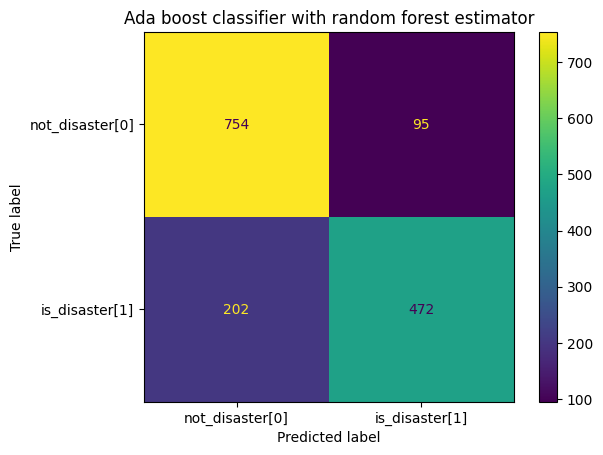

In [91]:
plot_confusion(y_test, preds, gs_ada, title="Ada boost classifier with random forest estimator")

## Read the test data for Kaggle submision

In [10]:
test = pd.read_csv('test.csv')

In [11]:
text_1 = pd.Series(test['text'])

In [12]:
text_1 

0                      Just happened a terrible car crash
1       Heard about #earthquake is different cities, s...
2       there is a forest fire at spot pond, geese are...
3                Apocalypse lighting. #Spokane #wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane. My city...
3260    Green Line derailment in Chicago http://t.co/U...
3261    MEG issues Hazardous Weather Outlook (HWO) htt...
3262    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 3263, dtype: object

In [322]:
## Add the cleaned text into the data DataFrame
test['text']=new_text_4

In [323]:
X_kaggle= pd.Series(test['text'])

In [86]:
predictions = loaded_model.predict(clean_the_text(pd.Series('situation here')))

In [87]:
predictions

array([1])

In [325]:
Results_Kaggle = pd.DataFrame({'id': test['id'],'target': predictions})

In [326]:
Results_Kaggle

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [52]:
#Results_Kaggle.to_csv('./Kalpa_Kaggle/svc_kalpa.csv',index = False)